# 3. Bouquet Flower Classification

## Objectives 
* Build or get a data set of image files of bouquet flowers. It must contain at least 10 categories of flowers and 25 images for each category.
* Generate the training data
    * Using Orange, generate the Image Embeddings por each dataset with Inception V3.
    * Save the Image Embeddings and use them in a Jupyter notebook.
* Try at least 2 features for each one pf the following classifiers:
    * Logistic Regression
    * Neural Networks
    * SVM
    * Random Forest
* Mesaure the performance of the models, get and analize the confusion matrix.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Read Data

In [2]:
df = pd.read_csv('./dataset.csv')

In [3]:
#Get the categories dictionary
from json import load
with open('./data/cat_to_name.json') as f:
    dictionary = load(f)

## Data Preprocessing

In the following block, it shows all the information about the dataset. Explaining a little, the nfeature is the result of the image embedding algorithm, and category is the target. The others features are the metadata of the image.

In [4]:
df.describe()

,id,n0,n1,n2,n3,n4,n5,n6,n7,n8,...,n2042,n2043,n2044,n2045,n2046,n2047,category,size,width,height
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,...,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,2591.934426,0.123907,0.296530,0.706586,0.423048,0.429640,0.231649,0.158231,0.486937,0.137223,...,0.209298,0.382003,0.841799,0.225658,0.419648,0.392623,5.688525,41176.189696,594.259953,562.072600
std,1934.192456,0.135906,0.357501,0.523713,0.328542,0.342191,0.180200,0.146348,0.318460,0.137656,...,0.205524,0.383193,0.736157,0.224748,0.344902,0.331344,2.766998,12408.781580,95.112660,93.095901
min,0.000000,0.000000,0.000000,0.009525,0.000691,0.004887,0.003033,0.000644,0.000592,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15537.000000,500.000000,500.000000
25%,686.500000,0.035596,0.048361,0.334935,0.170172,0.178533,0.097971,0.052761,0.250965,0.038579,...,0.043547,0.121556,0.277776,0.059730,0.164968,0.129059,3.000000,33126.500000,500.000000,500.000000
50%,2434.000000,0.079397,0.140451,0.596198,0.346462,0.337732,0.189693,0.118017,0.408534,0.092604,...,0.156200,0.253251,0.608361,0.156220,0.334962,0.312468,6.000000,39450.000000,587.000000,500.000000
75%,4870.500000,0.164688,0.414406,0.980846,0.620304,0.587902,0.322227,0.234049,0.668371,0.196230,...,0.308337,0.544424,1.264653,0.328793,0.604486,0.577325,8.000000,47660.000000,667.000000,625.000000
max,5862.000000,0.865708,1.968339,3.007994,1.787014,1.682581,0.969356,1.323634,1.633848,0.857329,...,0.952524,2.100790,3.332155,1.556095,2.032899,1.635965,10.000000,100863.000000,845.000000,928.000000


In [5]:
#Change the keys, from string to int
dictionary = { int(k): v for k, v in dictionary.items() }

In [6]:
#To know which flowers we have
print('Categories:')
keys = df.category.unique()
for k in keys:
    print(f'{k}: {dictionary[k]}')

Categories:
1: pink primrose
10: globe thistle
2: hard-leaved pocket orchid
3: canterbury bells
4: sweet pea
5: english marigold
6: tiger lily
7: moon orchid
8: bird of paradise
9: monkshood


In [7]:
#Separate our possible features from the target
X, y = df.drop(['category', 'size', 'width', 'height', 'image name', 'image', 'id'], axis=1), df['category']

In [8]:
#For selecting the best features, will use the next utilities from sklearn
from sklearn.feature_selection import SelectKBest, chi2
best_features = SelectKBest(chi2, k=10).fit(X, y)

In [9]:
#I will creating a new df with all the features and correlations with the target
n_features = 10
df_scores = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X.columns)

#concat
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Specs', 'Score']

features_to_use = list(feature_scores.nlargest(n_features, 'Score').Specs)
print(feature_scores.nlargest(n_features, 'Score'))

      Specs       Score
905    n905  355.705863
575    n575  255.663244
937    n937  235.079152
1161  n1161  216.241980
901    n901  214.548363
942    n942  201.386487
460    n460  185.586139
1637  n1637  176.106703
79      n79  174.974925
418    n418  173.187646


<AxesSubplot:>

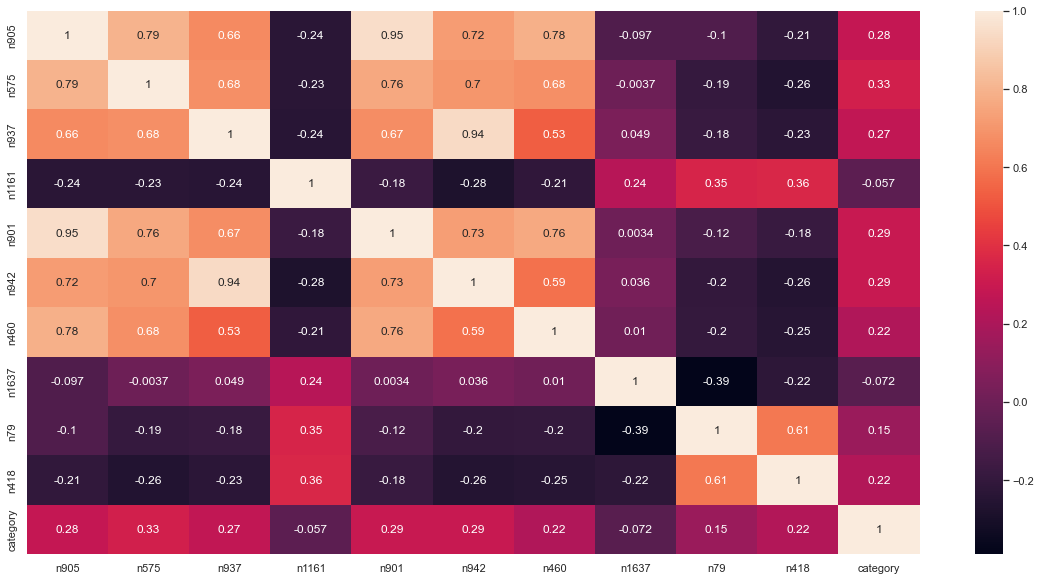

In [10]:
#To know how correleated are the features with the categories
%matplotlib inline
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(df[features_to_use + ['category']].corr(), annot=True)

As we can see, there is not too much correlationship between category and all the features, been bellow the 0.5 of correlation. However, there is a set of features strong correlated, so, it can be useful for the models.

In [11]:
#I'll separate the X from the selected features
x = X[features_to_use]

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
#For logistic regression, it is necessary to normalize 
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train, y_train)
x_test_scaled = standard_scaler.fit_transform(x_test, y_test)

## Model Creation

In [16]:
"""Logistic Regression"""
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

In [25]:
"""Neural networks"""
from sklearn.neural_network import MLPClassifier
neural_network = MLPClassifier(max_iter=500, solver='lbfgs')

In [18]:
"""SVM"""
from sklearn.svm import SVC
svm = SVC()

In [20]:
"""Random Forest"""
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

## Adjust Model with Historic Data

In [26]:
"""Logistic Regression"""
log_reg.fit(x_train_scaled, y_train)

LogisticRegression()

In [27]:
"""Neural network"""
neural_network.fit(x_train, y_train)

MLPClassifier(max_iter=500, solver='lbfgs')

In [28]:
"""SVM"""
svm.fit(x_train, y_train)

SVC()

In [29]:
random_forest.fit(x_train, y_train)

RandomForestClassifier()